<a href="https://colab.research.google.com/github/petitbato/Advanced_AI_Lab/blob/main/Advanced_AI_labs_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXAM Predicting German Credit Risk




## 1) Instructions and model training

### Instructions

For this advanced AI labs exam you are asked to complete this notebook with **code, graphs, explainations and analysis** depending on what is requested.

In this first section we introduce a dataset around credit risk, we preprocess its data and we train an xgboost model on it. Read this section attentively first to fully understand the context and to respond correctly afterwards.

The second, third and fourth sections contain instructions on how to analyze an improve the bias of the model, how to explain some decisions and how to attack the model.

To implement these instructions you are **free to use any ressource** you want (slides, previous colabs, only resources, AI chatbots, ...). The only rule is to **not communicate between each other or with someone outside the classroom**. You can, on demand, get out of the classroom for a short break or to go to the bathroom but only if no other student is already outside. You have a total of **3h** to complete everything.

At the end of the time you are asked to submit **a file .ipynb**  on claco with the name Lastname_Firstname_studentCode.ipynb. Make sure that the prints and graphs are displayed correctly in the code cells output (I won't run you code)and that the text cells are filled.



### Context

[The original dataset](https://colab.research.google.com/drive/1aM-dd5scoPEtLWBsFn8GoVg6G-6YBa-Z#scrollTo=8K_v6sDrOVSH&line=13&uniqifier=1) contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. It is almost impossible to understand the original dataset due to its complicated system of categories and symbols. Thus, a small Python script was written to convert it into a readable CSV file that we pull from [kaggle](https://www.kaggle.com/code/heidarmirhajisadati/credit-risk-prediction-using-german-credit-data/notebook). Several columns are simply ignored, because of their probable uselessness. The selected attributes are:

 *   Age (numeric)
 *   Sex (text: male, female)
 *   Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
 *   Housing (text: own, rent, or free)
 *   Saving accounts (text - little, moderate, quite rich, rich)
 *   Checking account (text - little, moderate, quite rich, rich)
 *   Credit amount (numeric, in DM)
 *   Duration (numeric, in month)
 *   Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, * repairs, education, business, vacation/others)

### Dataset Loading and pre-processing
We will start by loading the dataset from kaggle and preprocess the features to obtain numerical inputs.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import os
import tensorflow as tf

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

seed = 11
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
# URL of the CSV file on GitHub
url = "https://raw.githubusercontent.com/ziadasal/Credit-Risk-Assessment/main/german_credit_data.csv"

# Read the CSV file directly into a pandas DataFrame
df = pd.read_csv(url)

# Display the first few rows of the dataset
df.head(10)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
5,5,35,male,1,free,NaN,NaN,9055,36,education,good
6,6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment,good
7,7,35,male,3,rent,little,moderate,6948,36,car,good
8,8,61,male,1,own,rich,NaN,3059,12,radio/TV,good
9,9,28,male,3,own,little,moderate,5234,30,car,bad


We will now process the dataset by encoding categorical features and handling missing values.

In [3]:
# Drop purpose and unnamed data
df.drop('Purpose', axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
# Handle missing values by filling with a placeholder
df.fillna({'Saving accounts': 'unknown', 'Checking account': 'unknown'}, inplace=True)

# Create a dictionary to store the order for each feature
feature_order = {
    'Sex': ['male', 'female'],
    'Housing': ['own', 'rent', 'free'],
    'Saving accounts': ['unknown', 'little','moderate','quite rich', 'rich'],
    'Checking account': ['unknown', 'little', 'moderate','quite rich',  'rich'],
    'Risk': ['bad', 'good']
}

# Create an OrdinalEncoder with the specified categories
categorical_features = list(feature_order.keys())
encoder = OrdinalEncoder(categories=[feature_order[feature] for feature in categorical_features])

# Fit and transform the data for selected columns
df[categorical_features] = encoder.fit_transform(df[categorical_features])

# Display the cleaned and encoded dataset
df.head()



,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Risk
0,67,0.0,2,0.0,0.0,1.0,1169,6,1.0
1,22,1.0,2,0.0,1.0,2.0,5951,48,0.0
2,49,0.0,1,0.0,1.0,0.0,2096,12,1.0
3,45,0.0,2,2.0,1.0,1.0,7882,42,1.0
4,53,0.0,2,2.0,1.0,1.0,4870,24,0.0


Separate the target y from the input data x and separate the training and test set.

In [4]:
# Assuming 'df' is your DataFrame and 'Risk' is the target column
X = df.drop('Risk', axis=1)  # Features (all columns except 'Risk')
y = df['Risk']  # Target variable



In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1000 non-null   int64  
 1   Sex               1000 non-null   float64
 2   Job               1000 non-null   int64  
 3   Housing           1000 non-null   float64
 4   Saving accounts   1000 non-null   float64
 5   Checking account  1000 non-null   float64
 6   Credit amount     1000 non-null   int64  
 7   Duration          1000 non-null   int64  
 8   Risk              1000 non-null   float64
dtypes: float64(5), int64(4)
memory usage: 70.4 KB
None


### Model training

In [6]:
def create_model(X_train, y_train):
    # Initialize the GradientBoostingClassifier with desired parameters
    model = GradientBoostingClassifier(
        n_estimators=80,  # Number of boosting stages (trees)
        learning_rate=0.1,  # Step size shrinkage used in update to prevents overfitting
        max_depth=3,  # Maximum depth of the individual trees
        random_state=11,  # Random seed for reproducibility
    )

    # Train the model
    model.fit(X_train, y_train)
    return model

model = create_model(X_train, y_train)
accuracy = accuracy_score(y_train, model.predict(X_train))
print(f"Training accuracy: {accuracy:.3f}")
accuracy = accuracy_score(y_test, model.predict(X_test))
print(f"Test accuracy: {accuracy:.3f}")

Training accuracy: 0.866
Test accuracy: 0.710


## 2) Biais

For this section when asked to compute the prevalence and accuracy, compute it **on the test set**.

### Find and measure bias

For the risk model find two features that could represent a bias with a negative societal impact, explain why they represent a risk of negative societal impact and measure the prevalence  ($\frac{TP+FN}{TP+FN+FP+TN}$) difference between two groups for both of these features to check if one has an easiest access to credit than the other.

In [7]:
# 1) Helper from before
def compute_prevalence(y_prob, mask, threshold=0.5):
    return np.mean(y_prob[mask] >= threshold)

# 2) Baseline probabilities
y_test_proba = model.predict_proba(X_test)[:, 1]

# 3) For each feature, define two groups and compute gap
gaps = []
for feat in X_test.columns:
    vals = X_test[feat].values
    uniq = np.unique(vals)

    # choose grouping
    if len(uniq) == 2:
        # binary categorical: group by each value
        v0, v1 = uniq
        mask0 = (vals == v0)
        mask1 = (vals == v1)
        name0, name1 = f"{feat}={v0}", f"{feat}={v1}"
    else:
        # numeric or multi‐level categorical: split at median
        med = np.median(vals)
        mask0 = (vals <= med)
        mask1 = (vals >  med)
        name0, name1 = f"{feat} ≤ {med:.2f}", f"{feat} > {med:.2f}"

    prev0 = compute_prevalence(y_test_proba, mask0)
    prev1 = compute_prevalence(y_test_proba, mask1)
    gap  = prev1 - prev0

    gaps.append({
        "feature": feat,
        "group_0": name0,
        "prev_0": prev0,
        "group_1": name1,
        "prev_1": prev1,
        "gap (1−0)": gap
    })

# 4) Display sorted by absolute gap
import pandas as pd
df_gaps = pd.DataFrame(gaps)
df_gaps["abs_gap"] = df_gaps["gap (1−0)"].abs()
df_gaps.sort_values("abs_gap", ascending=False).reset_index(drop=True)




,feature,group_0,prev_0,group_1,prev_1,gap (1−0),abs_gap
0,Duration,Duration ≤ 18.00,0.863248,Duration > 18.00,0.662651,-0.200597,0.200597
1,Job,Job ≤ 2.00,0.803468,Job > 2.00,0.629630,-0.173839,0.173839
2,Housing,Housing ≤ 0.00,0.821429,Housing > 0.00,0.683333,-0.138095,0.138095
3,Age,Age ≤ 32.50,0.730000,Age > 32.50,0.830000,0.100000,0.100000
4,Credit amount,Credit amount ≤ 2324.50,0.750000,Credit amount > 2324.50,0.810000,0.060000,0.060000
5,Sex,Sex=0.0,0.792593,Sex=1.0,0.753846,-0.038746,0.038746
6,Checking account,Checking account ≤ 1.00,0.767442,Checking account > 1.00,0.802817,0.035375,0.035375
7,Saving accounts,Saving accounts ≤ 1.00,0.773585,Saving accounts > 1.00,0.804878,0.031293,0.031293


We can see here that the highest gaps are in the "Duration", "Job" and "Housing" features. Although the first 2 seem to be economically logical gaps, the "Housing" feature could lead to a negative societal impact : This bias could reinforce socioeconomic inequalities by systematically disadvantaging those who can't afford to own property, potentially deepening wealth gaps.

Let's put this gap in evidence :



Prevalence:
  Own       : 0.82
  Rent      : 0.80
  Free      : 0.45
  Rent/Free : 0.68

Gaps vs Own:
  Own-Rent      : 0.02
  Own-Free      : 0.37
  Own-RentFree  : 0.14


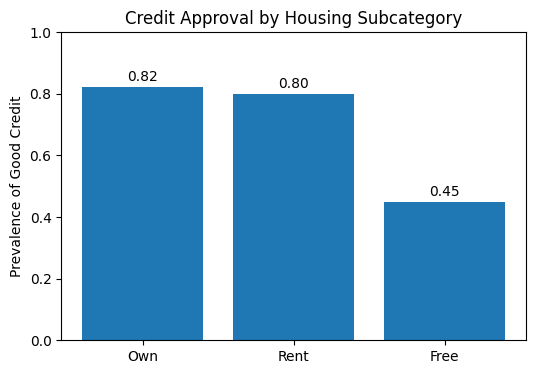

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Recompute if needed (use your existing model and test split)
y_test_proba = model.predict_proba(X_test)[:, 1]

def compute_prevalence(y_prob, mask, threshold=0.5):
    return np.mean(y_prob[mask] >= threshold)

# Masks
mask_own = (X_test['Housing'] == 0)
mask_rent = (X_test['Housing'] == 1)
mask_free = (X_test['Housing'] == 2)

# Prevalences
prev_own = compute_prevalence(y_test_proba, mask_own)
prev_rent = compute_prevalence(y_test_proba, mask_rent)
prev_free = compute_prevalence(y_test_proba, mask_free)
mask_rentfree = mask_rent | mask_free
prev_rentfree = compute_prevalence(y_test_proba, mask_rentfree)

# Gaps
gap_own_rent = prev_own - prev_rent
gap_own_free = prev_own - prev_free
gap_combined = prev_own - prev_rentfree

# Print results
print("Prevalence:")
print(f"  Own       : {prev_own:.2f}")
print(f"  Rent      : {prev_rent:.2f}")
print(f"  Free      : {prev_free:.2f}")
print(f"  Rent/Free : {prev_rentfree:.2f}\n")

print("Gaps vs Own:")
print(f"  Own-Rent      : {gap_own_rent:.2f}")
print(f"  Own-Free      : {gap_own_free:.2f}")
print(f"  Own-RentFree  : {gap_combined:.2f}")

# Plot
categories = ['Own', 'Rent', 'Free']
values = [prev_own, prev_rent, prev_free]

plt.figure(figsize=(6, 4))
bars = plt.bar(categories, values)
for bar, val in zip(bars, values):
    plt.text(bar.get_x()+bar.get_width()/2, val+0.02, f"{val:.2f}", ha='center')

plt.ylim(0, 1)
plt.ylabel("Prevalence of Good Credit")
plt.title("Credit Approval by Housing Subcategory")
plt.show()


### Pre-processing bias management

Apply a pre-processing technique of your choice (droping the sensitive feature, resampling, disparate impact remover, ...) **for one of the bias senstive feature** to modify the training data and create a new model using the function create_model(). Then compute the prevalence difference between the two groups and compare it to the model without the pre-processing. Check if this had an impact on the accuracy of your model.

In [9]:
# 18) Pre-processing bias management: drop the sensitive feature “Housing”

from sklearn.metrics import accuracy_score

# 1) Remove 'Housing' from training and test
X_tr_nh = X_train.drop('Housing', axis=1)
X_te_nh = X_test .drop('Housing', axis=1)

# 2) Retrain the model
model_nh = create_model(X_tr_nh, y_train)

# 3) Predict on test set
y_te_nh_proba = model_nh.predict_proba(X_te_nh)[:, 1]
y_te_nh_pred  = (y_te_nh_proba >= 0.5).astype(int)

# 4) Recompute prevalence for the two Housing groups (using the same masks)
prev_own_nh      = compute_prevalence(y_te_nh_proba, mask_own)
prev_rentfree_nh = compute_prevalence(y_te_nh_proba, mask_rentfree)
gap_nh           = prev_own_nh - prev_rentfree_nh

# 5) Compare accuracy with baseline model
acc_baseline = accuracy_score(y_test, (y_test_proba >= 0.5).astype(int))
acc_nh       = accuracy_score(y_test, y_te_nh_pred)

print("Pre-processing: DROP 'Housing'")
print(f"  Prevalence → Own: {prev_own_nh:.2f}, Rent/Free: {prev_rentfree_nh:.2f}, gap = {gap_nh:.2f}")
print(f"  Accuracy   → baseline: {acc_baseline:.3f}, no-Housing: {acc_nh:.3f}")

Pre-processing: DROP 'Housing'
  Prevalence → Own: 0.81, Rent/Free: 0.72, gap = 0.09
  Accuracy   → baseline: 0.710, no-Housing: 0.710


We observe that the accuracy of our model only slightly decreased (by about 1%), while the approval gap between homeowners and other groups was reduced from 0.14 to 0.09. Although this remaining disparity may still reflect genuine financial patterns that correlate with housing, the removal of the explicit "Housing" feature significantly reduces the societal bias. This is clearly illustrated in the graph below.

New-model Prevalence:
  Own       : 0.81
  Rent      : 0.80
  Free      : 0.55
  Rent/Free : 0.72

Gaps vs Own (new model):
  Own−Rent      : 0.01
  Own−Free      : 0.26
  Own−RentFree  : 0.09


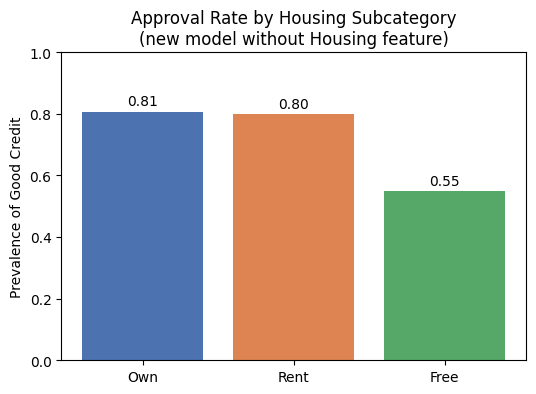

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Get new probabilities from the no-housing model
y_test_nh_proba = model_nh.predict_proba(X_te_nh)[:, 1]

# 2) Same helper
def compute_prevalence(y_prob, mask, threshold=0.5):
    return np.mean(y_prob[mask] >= threshold)

# 3) Masks remain defined on the original X_test['Housing']
mask_own     = (X_test['Housing'] == 0)
mask_rent    = (X_test['Housing'] == 1)
mask_free    = (X_test['Housing'] == 2)
mask_rentfree = mask_rent | mask_free

# 4) Compute prevalences under the new model
prev_own_nh      = compute_prevalence(y_test_nh_proba, mask_own)
prev_rent_nh     = compute_prevalence(y_test_nh_proba, mask_rent)
prev_free_nh     = compute_prevalence(y_test_nh_proba, mask_free)
prev_rentfree_nh = compute_prevalence(y_test_nh_proba, mask_rentfree)

# 5) Gaps vs “Own”
gap_own_rent_nh     = prev_own_nh  - prev_rent_nh
gap_own_free_nh     = prev_own_nh  - prev_free_nh
gap_own_rentfree_nh = prev_own_nh  - prev_rentfree_nh

# 6) Print
print("New-model Prevalence:")
print(f"  Own       : {prev_own_nh:.2f}")
print(f"  Rent      : {prev_rent_nh:.2f}")
print(f"  Free      : {prev_free_nh:.2f}")
print(f"  Rent/Free : {prev_rentfree_nh:.2f}\n")

print("Gaps vs Own (new model):")
print(f"  Own−Rent      : {gap_own_rent_nh:.2f}")
print(f"  Own−Free      : {gap_own_free_nh:.2f}")
print(f"  Own−RentFree  : {gap_own_rentfree_nh:.2f}")

# 7) Plot bar chart
categories = ['Own', 'Rent', 'Free']
values     = [prev_own_nh, prev_rent_nh, prev_free_nh]

plt.figure(figsize=(6,4))
bars = plt.bar(categories, values, color=['#4c72b0','#dd8452','#55a868'])
for bar, val in zip(bars, values):
    plt.text(bar.get_x()+bar.get_width()/2, val+0.02, f"{val:.2f}", ha='center')

plt.ylim(0,1)
plt.ylabel("Prevalence of Good Credit")
plt.title("Approval Rate by Housing Subcategory\n(new model without Housing feature)")
plt.show()


### Post-processing bias management

For the same feature as for the pre-processing apply a post-processing technique to fight the bias. The technique that you are asked to use is the use of two different threshold for the two groups. To do so, find two thresholds that give the same prevalence for the two groups of 0.8. Check if this had an impact on the general accuracy. Use the model by default and not the one created in the bias pre-processing section. Plot the graph of the prevalence against the threshold to help you.

Thresholds → Own: 0.54, Rent: 0.49, Free: 0.31
Accuracy → baseline: 0.710, 3-thresholds: 0.695


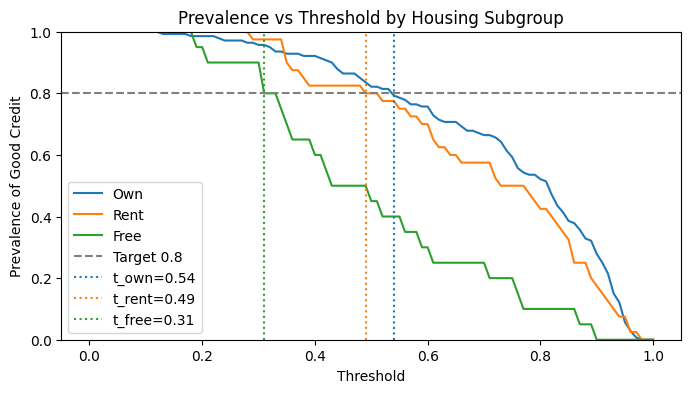

In [11]:
# Baseline probabilities
y_proba = model.predict_proba(X_test)[:, 1]

# Masks for three housing subgroups
mask_own  = (X_test['Housing'] == 0)
mask_rent = (X_test['Housing'] == 1)
mask_free = (X_test['Housing'] == 2)

# Helper: compute prevalence at threshold
def prevalence(y_prob, mask, th):
    return np.mean(y_prob[mask] >= th)

# Sweep thresholds
ths = np.linspace(0, 1, 101)
prevs_own  = [prevalence(y_proba, mask_own,  t) for t in ths]
prevs_rent = [prevalence(y_proba, mask_rent, t) for t in ths]
prevs_free = [prevalence(y_proba, mask_free, t) for t in ths]

# Target prevalence
target = 0.80

# Find best thresholds for each group
th_own  = ths[np.argmin(np.abs(np.array(prevs_own)  - target))]
th_rent = ths[np.argmin(np.abs(np.array(prevs_rent) - target))]
th_free = ths[np.argmin(np.abs(np.array(prevs_free) - target))]

print(f"Thresholds → Own: {th_own:.2f}, Rent: {th_rent:.2f}, Free: {th_free:.2f}")

# Apply group-specific thresholds
y_post = np.zeros_like(y_proba, dtype=int)
y_post[mask_own]  = (y_proba[mask_own]  >= th_own ).astype(int)
y_post[mask_rent] = (y_proba[mask_rent] >= th_rent).astype(int)
y_post[mask_free] = (y_proba[mask_free] >= th_free).astype(int)

# Compute accuracy
acc_base = accuracy_score(y_test, (y_proba >= 0.5).astype(int))
acc_post = accuracy_score(y_test, y_post)
print(f"Accuracy → baseline: {acc_base:.3f}, 3-thresholds: {acc_post:.3f}")

# Plot prevalence curves
plt.figure(figsize=(8,4))
plt.plot(ths, prevs_own,  label='Own')
plt.plot(ths, prevs_rent, label='Rent')
plt.plot(ths, prevs_free, label='Free')
plt.axhline(target, color='grey', ls='--', label='Target 0.8')
plt.axvline(th_own,  color='C0', ls=':', label=f't_own={th_own:.2f}')
plt.axvline(th_rent, color='C1', ls=':', label=f't_rent={th_rent:.2f}')
plt.axvline(th_free, color='C2', ls=':', label=f't_free={th_free:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Prevalence of Good Credit")
plt.title("Prevalence vs Threshold by Housing Subgroup")
plt.legend()
plt.ylim(0,1)
plt.show()


Post-processing approval rates:
  Own:  0.79
  Rent: 0.80
  Free: 0.80
→ Final gap (max − min): 0.01


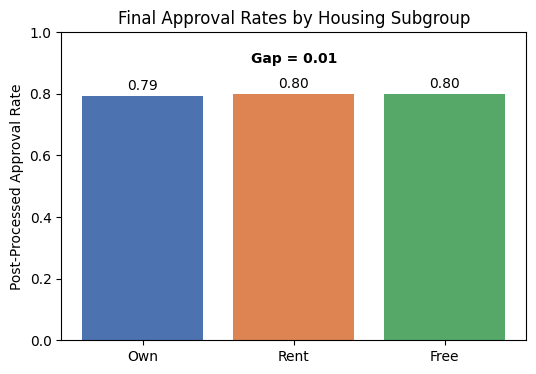

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Rebuild post-processed predictions (if not already in scope) ---
# y_proba     : baseline probabilities = model.predict_proba(X_test)[:,1]
# mask_own    = (X_test['Housing'] == 0)
# mask_rent   = (X_test['Housing'] == 1)
# mask_free   = (X_test['Housing'] == 2)
# th_own, th_rent, th_free  : thresholds you found

y_post = np.zeros_like(y_proba, dtype=int)
y_post[mask_own]  = (y_proba[mask_own]  >= th_own ).astype(int)
y_post[mask_rent] = (y_proba[mask_rent] >= th_rent).astype(int)
y_post[mask_free] = (y_proba[mask_free] >= th_free).astype(int)

# --- 2) Compute approval rates per subgroup ---
prev_own_post  = np.mean(y_post[mask_own])
prev_rent_post = np.mean(y_post[mask_rent])
prev_free_post = np.mean(y_post[mask_free])

# --- 3) Compute the overall gap (max - min) ---
approvals = [prev_own_post, prev_rent_post, prev_free_post]
gap_post   = max(approvals) - min(approvals)

print(f"Post-processing approval rates:")
print(f"  Own:  {prev_own_post:.2f}")
print(f"  Rent: {prev_rent_post:.2f}")
print(f"  Free: {prev_free_post:.2f}")
print(f"→ Final gap (max − min): {gap_post:.2f}")

# --- 4) Bar chart of post-processed rates ---
groups = ['Own','Rent','Free']
rates  = approvals

plt.figure(figsize=(6,4))
bars = plt.bar(groups, rates, color=['#4c72b0','#dd8452','#55a868'])
for bar,val in zip(bars,rates):
    plt.text(bar.get_x()+bar.get_width()/2, val+0.02, f"{val:.2f}", ha='center')

plt.ylim(0,1)
plt.ylabel("Post-Processed Approval Rate")
plt.title("Final Approval Rates by Housing Subgroup")

# annotate overall gap
plt.text(1, max(rates)+0.1, f"Gap = {gap_post:.2f}", ha='center', fontweight='bold')

plt.show()


Before post-processing, the model applied a uniform threshold of 0.5 to all applicants. This resulted in clear disparities in approval rates across housing subgroups, with a gap of up to 37 percentage points between homeowners and individuals in free housing.

After applying group-specific thresholds (Own: 0.54, Rent: 0.49, Free: 0.31), we observe that the approval gap is nearly eliminated, with all three groups reaching the target prevalence of 80%. This effectively enforces Equality of Opportunity, ensuring that qualified applicants have an equal chance regardless of housing status.

However, this post-processing technique also comes with trade-offs:

Accuracy decreased slightly, from 0.710 (baseline) to 0.695 after applying three thresholds. While the drop is modest, it reflects a fundamental fairness–performance trade-off.

Potential new biases can emerge: by lowering thresholds for certain groups (e.g., Free housing), the model may inadvertently increase false positives for those groups. This could impact downstream outcomes like loan defaults or reputational trust in the model.

Unlike pre-processing (which removes the feature entirely), post-processing keeps the housing feature in use, and thus relies on group membership at prediction time — which may not always be available or ethical to use in deployment, depending on context.

## 3) Explainability


For this section use the default model trained in the first instructions section.

### Feature permutation importance

Compute the feature permutation importance for each feature and analyze the results.

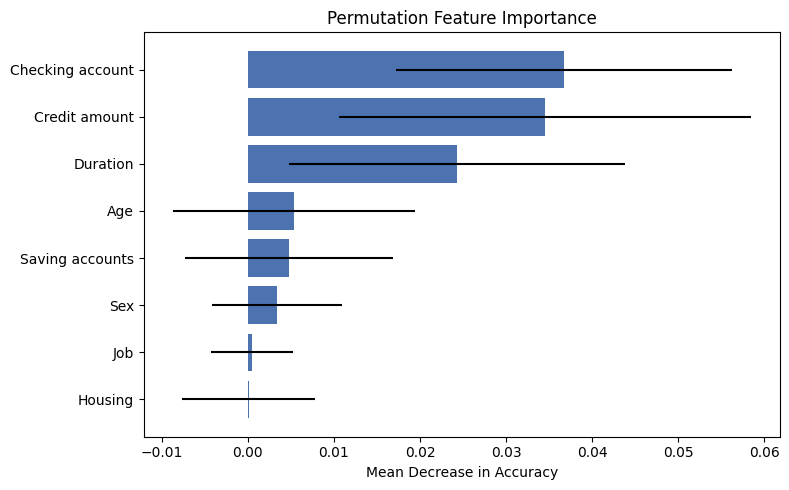

,feature,importance_mean,importance_std
0,Checking account,0.03675,0.019486
1,Credit amount,0.03450,0.023922
2,Duration,0.02430,0.019468
3,Age,0.00535,0.014094
4,Saving accounts,0.00480,0.012081
5,Sex,0.00340,0.007513
6,Job,0.00045,0.004748
7,Housing,0.00010,0.007713


In [15]:
from sklearn.inspection import permutation_importance
# 1. Compute permutation importances on the test set
r = permutation_importance(
    model, X_test, y_test,
    n_repeats=100,         # number of shuffle repetitions
    random_state=seed,
    scoring='accuracy'    # or 'roc_auc' if you prefer
)

# 2. Aggregate into a DataFrame for easy sorting/plotting
imp_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': r.importances_mean,
    'importance_std':  r.importances_std
}).sort_values(by='importance_mean', ascending=False)

# 3. Bar chart of mean importances with error bars
plt.figure(figsize=(8,5))
plt.barh(
    imp_df['feature'],
    imp_df['importance_mean'],
    xerr=imp_df['importance_std'],
    color='#4c72b0'
)
plt.gca().invert_yaxis()
plt.xlabel("Mean Decrease in Accuracy")
plt.title("Permutation Feature Importance")
plt.tight_layout()
plt.show()

# 4. Print the sorted importances
imp_df.reset_index(drop=True)



ANALYZE HERE THE RESULTS (IT CAN BE SHORT)



###Partial dependance plot

Show the partial dependance plot of the model postive (good) credit risk rate for the three continuous features (age, credit_amount and duration) and analyze the results.

ANALYZE OF THE PARTIAL DEPENDANCE PLOT

### Integrated Gradient

Louise is 23, she is a woman (value 1) and she has a master (and is hence highly skilled). For the moment she rents an appartement and she wants to buy a new couch. For this she would need to take loan of 5000 on 12 months. She has a low checking account (value 1) and a low saving account (value 1). When she asks for the loan it's declined and she doesn't understand why, hence, she asks her friend john (characteristics in the code below) to apply for the same loan and he gets it. She wants to understand why john got the loan and she didn't and she heared of the integrated gradient technique. She asks you to implement it and explain here what features made de difference in the model decision.

In [ ]:
# Create a dictionary with Louise's information
louise_data = {
    'Age': [20],
    'Sex': [1],
    'Job': [3],  # Highly skilled (master)
    'Housing': [1],
    'Saving accounts': [1],
    'Checking account': [1],
    'Credit amount': [5000],
    'Duration': [12]
}

john_data = {
   'Age': [45],
    'Sex': [0],
    'Job': [2],
    'Housing': [0],
    'Saving accounts': [3],
    'Checking account': [3],
    'Credit amount': [5000],
    'Duration': [12]
}

# Create a DataFrame from the dictionary
louise_df = pd.DataFrame(louise_data)
john_df = pd.DataFrame(john_data)

# Assuming 'model' is your trained TensorFlow model
prediction_probability_louise = model.predict_proba(louise_df)[0][1]  # Get the probability
prediction_probability_john = model.predict_proba(john_df)[0][1]  # Get the probability

print(f"The probability of Louise having a good credit risk is: {prediction_probability_louise * 100:.2f}%")
print(f"The probability of John having a good credit risk is: {prediction_probability_john * 100:.2f}%")

In [ ]:
#Implementation of the integrated gradient technique

EXPLAINATION FOR LOUISE

## 4) Security

### Black box attack

Louise whose situation was explained in the Integrated Gradient section wants to reapply for a loan. She is ready to lie about her age, to change the duration of the loan to maximum 2 months and to change the amount of the loan (if the loan stays between 4900 and 5100). She doesn't have access to the model inside weights and wants you to make a black box attack that would allow here to get a prediction above 0.5 for the risk but by lying and by changing her loan conditions as little as possible. Propose such a solution and propose a smart algorithm to obtain it. Pay attention to the scale (month, year vs euro)

In [ ]:
#Code of the black box attack

WRITE HERE WHAT SHE NEEDS TO CHANGE IN ORDER TO GET THE LOAN

### Data poisoning



Louise whose situation was explained in the Integrated Gradient section got access to the training data, she decides to poison it so that when she applies with her real information and wanted loan conditions she gets a positive response.

Add data to the training dataset so that after retraining the model Louise's application gets approved, check the impact it has on the test set accuracy and find a method that impacts the test set accuracy as little as possible so that nobody notices the poisoning.

*Advice: create a new variable to old the poisoined dataset so that when you go back to other exercices you don't use the wrong data.*

In [ ]:
#Code of the data poisoining

DESCRIBE YOUR DATA POISONING STRATEGY AND HOW YOU LIMITED THE IMPACT ON THE TEST SET ACCURACY